## Take Home Assessment

**Disclaimer**: This assessment is work in progress, so we apologise in advance for any hiccup. Any feedback is valuable!

**Setup**: You are provided with some training code for a model that takes protein 3D structure and predicts the associated amino acid sequence. This notebook provides the required steps to download the code repository and training data (a subset of the Protein Data Bank), alongside minimal code to call the training loop. Please fork the repository that you can find below and edit your own version.

**Compute**: You will be provided a [Lambda](https://cloud.lambdalabs.com/) instance with a A10 GPU on an agreed day. For this we need your public key and we will share an IP address to access the compute instance.

**Evaluation**: The following questions are on purpose quite open-ended. No specific answer is expected. The aim is to provide a semi-realistic setup that you may encounter if you were to join our team. We want to assess your ability to probe deep learning models and to come up with solutions to alleviate potential identified limitations. Please write down your answers (e.g. with plots, tables etc) in your copy of the repository (e.g. in this notebook or in any other format of your choice) and push them to your fork. Do include any documentation of what all you did to arrive at your answers. We will discuss during the onsite interview. Please keep the time commitment under 4h.

**Questions**:
1. Log and profile the training loop.  What would you recommend if we wanted to train more quickly? Implement some of your proposals.
2. What kinds of issues will arise as model size increases? How could these be partially alleviated? Implement some of your proposed solutions.
3. The way the dataloader is organized in this project is unusual.  What will happen as we increase the size of the training dataset (e.g. using the AlphaFold database)?  How would you re-organize the code to avoid these issues?  What techniques would you consider using to ensure training scales efficiently with the dataset size?
4. Log the average norm of the weights & activations through training. How would you organize this information to help diagnose training dynamics?  How would you characterize the values you observe here?

# Initial observations

- Hey, this code looks strangely familiar... looks like ProteinMPNN!
- In the cells below, I will answer the questions out-of-order but in a way that I think makes sense.

# Data download

In [1]:
# Download subset of training data
!wget https://files.ipd.uw.edu/pub/training_sets/pdb_2021aug02_sample.tar.gz
!tar xvf "pdb_2021aug02_sample.tar.gz"
!rm pdb_2021aug02_sample.tar.gz

--2024-10-04 21:56:24--  https://files.ipd.uw.edu/pub/training_sets/pdb_2021aug02_sample.tar.gz
Resolving files.ipd.uw.edu (files.ipd.uw.edu)... 128.95.160.134, 128.95.160.135, 2607:4000:406::160:135, ...
Connecting to files.ipd.uw.edu (files.ipd.uw.edu)|128.95.160.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49690915 (47M) [application/octet-stream]
Saving to: ‘pdb_2021aug02_sample.tar.gz’

pdb_2021aug02_sampl 100%[===================>]  47.39M  16.3MB/s    in 2.9s    

2024-10-04 21:56:28 (16.3 MB/s) - ‘pdb_2021aug02_sample.tar.gz’ saved [49690915/49690915]

./pdb_2021aug02_sample/
./pdb_2021aug02_sample/README
./pdb_2021aug02_sample/list.csv
./pdb_2021aug02_sample/pdb/
./pdb_2021aug02_sample/pdb/l3/
./pdb_2021aug02_sample/pdb/l3/5l3p.pt
./pdb_2021aug02_sample/pdb/l3/5l3g_A.pt
./pdb_2021aug02_sample/pdb/l3/5l3f.pt
./pdb_2021aug02_sample/pdb/l3/5l3r_B.pt
./pdb_2021aug02_sample/pdb/l3/4l3o_G.pt
./pdb_2021aug02_sample/pdb/l3/1l3b_E.pt
./pdb_2021aug02_sam

# 3. Data loading
The way the dataloader is organized in this project is unusual.  What will happen as we increase the size of the training dataset (e.g. using the AlphaFold database)?  How would you re-organize the code to avoid these issues?  What techniques would you consider using to ensure training scales efficiently with the dataset size?

- The dataloader is already well-organized to minimize the I/O time spent loading from disk.
  - PDBs are processed so that the smallest atom of training (a single chain from a single pdb id) is in its own file.
  - Each of these has a corresponding lightweight metadata file that allows for fast selection of training instances without loading the full example.
  - The dataloader also performs processing to generate assemblies on-the-fly. The auxiliary DataLoader, `train_loader`, provides randomly transformed assemblies every `args.reload_data_every_n_epochs` to the primary DataLoader, `loader_train`. This could be a bottleneck, but it is alleviated by running asynchronously on cpu during model training, so it doesn't interfere with training.
- However, if the auxiliary dataloader were used on a huge dataset like the AlphaFold dataset, the training would outpace the auxiliary dataloader and you would be left waiting forever at `pdb_dict_train = q.get().result()`. 
  - You could alleviate this by increasing the `args.reload_data_every_n_epochs` parameter, but that probably still would be insufficient. 
  - I don't understand exactly what the transforms here do, but I think they generate the bioassembly from the asymmetric unit. Since the model is SE(3)-invariant, I don't know exactly why this is necessary, since these are rotations and translations of the same asymmetric unit, offering no additional diversity to a model that is agnostic to SE(3) transforms. AlphaFold also doesn't provide transforms in its predicted PDBs, so I don't think this information would be present. I would probably dispense with the auxiliary dataloader and use only the primary dataloader. 
  - If these transforms are necessary, I would push them into the normal dataloader as long as I didn't see a data loading bottleneck.

# 1. Profiling the training loop
Log and profile the training loop.  What would you recommend if we wanted to train more quickly? Implement some of your proposals.

## Profiling existing training loop

In [2]:
from training.training import main as run_training
import random
import numpy as np
import torch

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class MyArgs(object):
  def __init__(self):
    self.path_for_training_data = "./pdb_2021aug02_sample"
    self.path_for_outputs = "./content/test"
    self.previous_checkpoint = ""
    self.num_epochs = 2
    self.save_model_every_n_epochs = 5
    self.reload_data_every_n_epochs = 4
    self.num_examples_per_epoch = 200
    self.batch_size = 2000
    self.max_protein_length = 2000
    self.hidden_dim = 128
    self.num_encoder_layers = 3
    self.num_decoder_layers = 3
    self.num_neighbors = 32
    self.dropout = 0.1
    self.backbone_noise = 0.1
    self.rescut = 3.5
    self.debug = True
    self.gradient_norm = -1.0 #no norm
    self.decoder_use_full_cross_attention = True
    self.cross_attention_num_heads = 4
    self.mixed_precision = False
    self.compute_categorical_jacobian = False

args = MyArgs()
run_training(args)

/home/ubuntu/takehome-re-jacobastern/training/training.py:250: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for 

epoch: 1, step: 7, time: 1.5, train: 58.141, valid: 50.003, train_acc: 0.016, valid_acc: 0.013
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    autograd::engine::evaluate_function: AddmmBackward0         0.47%       5.231ms         5.12%      57.143ms     181.407us       0.000us         0.00%      97.829ms     310.567us           315  
                                               aten::mm         1.23%      13.739ms         2.89%      32.194ms 

100%|██████████| 7/7 [00:00<00:00, 17.12it/s]


epoch: 2, step: 14, time: 0.4, train: 44.589, valid: 34.875, train_acc: 0.026, valid_acc: 0.024
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    autograd::engine::evaluate_function: AddmmBackward0         1.52%       5.035ms        13.07%      43.259ms     137.331us       0.000us         0.00%      99.454ms     315.726us           315  
                                               aten::mm         4.19%      13.870ms         6.12%      20.263ms

## Observations
CPU time is about equal with GPU time, so without doing extensive profiling, it looks like the dataloader is doing a decent job of keeping the GPUs fed. This means that model performance improvements are likely to help. I implemented AMP, with the caveat that I was directly inspired by the ProteinMPNN implementation.

## Profile with AMP

In [1]:
from training.training import main as run_training
import random
import numpy as np
import torch

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class MyArgs(object):
  def __init__(self):
    self.path_for_training_data = "./pdb_2021aug02_sample"
    self.path_for_outputs = "./content/test"
    self.previous_checkpoint = ""
    self.num_epochs = 2
    self.save_model_every_n_epochs = 5
    self.reload_data_every_n_epochs = 4
    self.num_examples_per_epoch = 200
    self.batch_size = 2000
    self.max_protein_length = 2000
    self.hidden_dim = 128
    self.num_encoder_layers = 3
    self.num_decoder_layers = 3
    self.num_neighbors = 32
    self.dropout = 0.1
    self.backbone_noise = 0.1
    self.rescut = 3.5
    self.debug = True
    self.gradient_norm = -1.0 #no norm
    self.decoder_use_full_cross_attention = True
    self.cross_attention_num_heads = 4
    self.mixed_precision = True
    self.compute_categorical_jacobian = False

args = MyArgs()
run_training(args)

/home/ubuntu/takehome-re-jacobastern/training/training.py:175: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/training/training.py:250: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpi

epoch: 1, step: 6, time: 1.3, train: 58.912, valid: 51.906, train_acc: 0.018, valid_acc: 0.009
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                               Optimizer.step#Adam.step         0.00%       0.000us         0.00%       0.000us       0.000us      79.188ms        27.98%      79.188ms      13.198ms             6  
                                            aten::copy_         3.81%      45.533ms        10.45%     124.743ms 

100%|██████████| 6/6 [00:00<00:00, 14.97it/s]


epoch: 2, step: 12, time: 0.4, train: 47.865, valid: 38.174, train_acc: 0.021, valid_acc: 0.018
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::copy_         5.45%      17.711ms        18.41%      59.862ms      25.670us      37.024ms        17.82%      39.670ms      17.011us          2332  
                                           aten::linear         1.13%       3.681ms        15.60%      50.725ms

## Observations
Training with AMP offered a noticeable reduction in CUDA time. It looks like we may be dataloader bottlenecked at this point - I would like to do more profiling to see if we are stalling at the dataloader but I ran out of time. I would also like to train longer to assess the effect of AMP on model performance.

# 2. Model improvement
What kinds of issues will arise as model size increases? How could these be partially alleviated? Implement some of your proposed solutions.

You could hit memory errors and slower training if the model were to get big enough, since the spatial and computational complexity of updating nodes by all other nodes scales quadratically with sequence length. However, the k_neighbors argument, which limits the complexity to O(N * k), alleviates that issue.

Possible improvements:
- Train on spatial crops. Similar to k_neighbors, but would allow full self-attention. Training algorithm:
  - Sample a pdb
  - Sample a residue in that pdb
  - Condition on all structure within a 50 A radius of that residue.
  - Supervise all residues within a 20 A crop of that residue (to avoid training residues near the edge of the spatial crop).
  - At inference time, you can scan over residues and perform a spatial crop for each when performing inference for that residue. This has the downside of needing to re-encode structure at each step. Really, the k_neighbors solution where you encode the full structure once and then select node embeddings based on neighbors is a much more elegant way to solve this problem.
- Use a Mamba-like architecture to perform linear attention.
- Perform an ablation of encoder size vs. decoder size - for a fixed FLOPS budget, what is the optimal tradeoff between encoder size and decoder size?
- This is not necessarily a model scaling improvement, but I noticed that this model does not use true attention. 
  - I made changes to model_utils.py to replace the message-passing "attention" with true cross attention to see if that offered improvement.

## Model with message passing

In [1]:
from training.training import main as run_training
import random
import numpy as np
import torch

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class MyArgs(object):
  def __init__(self):
    self.path_for_training_data = "./pdb_2021aug02_sample"
    self.path_for_outputs = "./content/test"
    self.previous_checkpoint = ""
    self.num_epochs = 50
    self.save_model_every_n_epochs = 5
    self.reload_data_every_n_epochs = 4
    self.num_examples_per_epoch = 200
    self.batch_size = 2000
    self.max_protein_length = 2000
    self.hidden_dim = 128
    self.num_encoder_layers = 3
    self.num_decoder_layers = 3
    self.num_neighbors = 32
    self.dropout = 0.1
    self.backbone_noise = 0.1
    self.rescut = 3.5
    self.debug = False
    self.gradient_norm = -1.0 #no norm
    self.decoder_use_full_cross_attention = False
    self.cross_attention_num_heads = 4
    self.mixed_precision = True
    self.compute_categorical_jacobian = False

args = MyArgs()
run_training(args)

/home/ubuntu/takehome-re-jacobastern/training/training.py:163: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/training/training.py:238: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpi

epoch: 1, step: 7, time: 1.2, train: 50.536, valid: 45.072, train_acc: 0.052, valid_acc: 0.071


100%|██████████| 7/7 [00:00<00:00, 28.23it/s]


epoch: 2, step: 14, time: 0.3, train: 39.723, valid: 29.619, train_acc: 0.052, valid_acc: 0.065


100%|██████████| 7/7 [00:00<00:00, 27.46it/s]


epoch: 3, step: 21, time: 0.3, train: 29.191, valid: 22.885, train_acc: 0.063, valid_acc: 0.100


100%|██████████| 7/7 [00:00<00:00, 29.02it/s]


epoch: 4, step: 28, time: 0.3, train: 24.336, valid: 19.624, train_acc: 0.081, valid_acc: 0.086


100%|██████████| 6/6 [00:00<00:00, 18.86it/s]
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt"

epoch: 5, step: 34, time: 0.6, train: 22.105, valid: 18.730, train_acc: 0.082, valid_acc: 0.072


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 6, step: 40, time: 0.3, train: 21.076, valid: 17.942, train_acc: 0.080, valid_acc: 0.083


100%|██████████| 6/6 [00:00<00:00, 24.32it/s]


epoch: 7, step: 46, time: 0.3, train: 20.019, valid: 17.508, train_acc: 0.089, valid_acc: 0.113


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 8, step: 52, time: 0.3, train: 19.535, valid: 17.690, train_acc: 0.096, valid_acc: 0.098


100%|██████████| 7/7 [00:00<00:00, 20.35it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 9, step: 59, time: 0.7, train: 19.571, valid: 17.351, train_acc: 0.093, valid_acc: 0.093


 43%|████▎     | 3/7 [00:00<00:00, 23.13it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 10, step: 66, time: 0.4, train: 19.046, valid: 17.089, train_acc: 0.103, valid_acc: 0.103


 43%|████▎     | 3/7 [00:00<00:00, 22.75it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 11, step: 73, time: 0.3, train: 18.582, valid: 16.895, train_acc: 0.111, valid_acc: 0.109


100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


epoch: 12, step: 80, time: 0.4, train: 18.395, valid: 16.777, train_acc: 0.108, valid_acc: 0.115


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 13, step: 86, time: 0.7, train: 18.280, valid: 18.243, train_acc: 0.101, valid_acc: 0.124


 50%|█████     | 3/6 [00:00<00:00, 22.44it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 14, step: 92, time: 0.4, train: 18.063, valid: 18.193, train_acc: 0.108, valid_acc: 0.134


 50%|█████     | 3/6 [00:00<00:00, 24.35it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 15, step: 98, time: 0.3, train: 17.866, valid: 18.514, train_acc: 0.107, valid_acc: 0.122


100%|██████████| 6/6 [00:00<00:00, 21.69it/s]
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt"

epoch: 16, step: 104, time: 0.4, train: 17.679, valid: 18.495, train_acc: 0.107, valid_acc: 0.116


100%|██████████| 6/6 [00:00<00:00, 22.57it/s]


epoch: 17, step: 110, time: 0.6, train: 17.735, valid: 16.405, train_acc: 0.117, valid_acc: 0.109


 50%|█████     | 3/6 [00:00<00:00, 25.16it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 18, step: 116, time: 0.3, train: 17.604, valid: 16.296, train_acc: 0.118, valid_acc: 0.107


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 19, step: 122, time: 0.4, train: 17.410, valid: 16.334, train_acc: 0.128, valid_acc: 0.112


100%|██████████| 6/6 [00:00<00:00, 20.89it/s]
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt"

epoch: 20, step: 128, time: 0.3, train: 17.369, valid: 16.219, train_acc: 0.121, valid_acc: 0.104


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 21, step: 134, time: 0.7, train: 16.802, valid: 18.213, train_acc: 0.132, valid_acc: 0.133


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 22, step: 140, time: 0.3, train: 16.490, valid: 18.083, train_acc: 0.133, valid_acc: 0.138


 50%|█████     | 3/6 [00:00<00:00, 22.68it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 23, step: 146, time: 0.6, train: 16.346, valid: 17.574, train_acc: 0.133, valid_acc: 0.146


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chains = {c:torch.load("%s_%s.pt"%(PREF

epoch: 24, step: 152, time: 0.4, train: 16.157, valid: 17.604, train_acc: 0.142, valid_acc: 0.132


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 25, step: 158, time: 0.4, train: 16.468, valid: 17.937, train_acc: 0.134, valid_acc: 0.124


 50%|█████     | 3/6 [00:00<00:00, 24.06it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 26, step: 164, time: 0.4, train: 16.299, valid: 18.177, train_acc: 0.130, valid_acc: 0.127


100%|██████████| 6/6 [00:00<00:00, 16.94it/s]


epoch: 27, step: 170, time: 0.4, train: 16.010, valid: 17.668, train_acc: 0.136, valid_acc: 0.133


 33%|███▎      | 2/6 [00:00<00:00, 19.28it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 28, step: 176, time: 0.4, train: 15.777, valid: 18.227, train_acc: 0.140, valid_acc: 0.133


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 29, step: 183, time: 0.7, train: 16.398, valid: 16.814, train_acc: 0.133, valid_acc: 0.139


100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


epoch: 30, step: 190, time: 0.4, train: 16.496, valid: 17.093, train_acc: 0.136, valid_acc: 0.134


 57%|█████▋    | 4/7 [00:00<00:00, 18.74it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 31, step: 197, time: 0.5, train: 16.282, valid: 16.912, train_acc: 0.140, valid_acc: 0.141


100%|██████████| 7/7 [00:00<00:00, 18.95it/s]


epoch: 32, step: 204, time: 0.4, train: 16.539, valid: 16.899, train_acc: 0.130, valid_acc: 0.123


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 33, step: 212, time: 0.6, train: 15.492, valid: 15.607, train_acc: 0.145, valid_acc: 0.137


  0%|          | 0/8 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 34, step: 220, time: 0.4, train: 14.964, valid: 14.588, train_acc: 0.148, valid_acc: 0.134


100%|██████████| 8/8 [00:00<00:00, 22.87it/s]


epoch: 35, step: 228, time: 0.4, train: 14.794, valid: 15.144, train_acc: 0.155, valid_acc: 0.140


  0%|          | 0/8 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 36, step: 236, time: 0.4, train: 14.364, valid: 14.537, train_acc: 0.162, valid_acc: 0.147


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 37, step: 240, time: 0.5, train: 14.428, valid: 14.774, train_acc: 0.161, valid_acc: 0.142


100%|██████████| 4/4 [00:00<00:00, 23.56it/s]


epoch: 38, step: 244, time: 0.2, train: 14.302, valid: 14.750, train_acc: 0.161, valid_acc: 0.144


  0%|          | 0/4 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 39, step: 248, time: 0.3, train: 14.088, valid: 14.712, train_acc: 0.170, valid_acc: 0.152


100%|██████████| 4/4 [00:00<00:00, 19.90it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 40, step: 252, time: 0.2, train: 13.907, valid: 14.757, train_acc: 0.181, valid_acc: 0.144


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 41, step: 258, time: 0.7, train: 14.006, valid: 14.573, train_acc: 0.168, valid_acc: 0.127


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 42, step: 264, time: 0.3, train: 13.899, valid: 14.490, train_acc: 0.161, valid_acc: 0.144


 33%|███▎      | 2/6 [00:00<00:00, 19.91it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 43, step: 270, time: 0.3, train: 13.519, valid: 14.694, train_acc: 0.172, valid_acc: 0.128


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 44, step: 276, time: 0.3, train: 13.319, valid: 14.169, train_acc: 0.177, valid_acc: 0.140


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 45, step: 282, time: 0.7, train: 15.176, valid: 14.880, train_acc: 0.159, valid_acc: 0.139


 50%|█████     | 3/6 [00:00<00:00, 20.34it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 46, step: 288, time: 0.4, train: 15.075, valid: 14.446, train_acc: 0.159, valid_acc: 0.159


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 47, step: 294, time: 0.3, train: 14.629, valid: 14.436, train_acc: 0.168, valid_acc: 0.147


 50%|█████     | 3/6 [00:00<00:00, 29.27it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 48, step: 300, time: 0.3, train: 14.301, valid: 14.251, train_acc: 0.173, valid_acc: 0.147


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 49, step: 305, time: 0.6, train: 14.202, valid: 14.453, train_acc: 0.175, valid_acc: 0.153


100%|██████████| 5/5 [00:00<00:00, 22.41it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 50, step: 310, time: 0.3, train: 13.842, valid: 14.239, train_acc: 0.178, valid_acc: 0.149


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

## Model with full cross attention

In [1]:
from training.training import main as run_training
import random
import numpy as np
import torch

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class MyArgs(object):
  def __init__(self):
    self.path_for_training_data = "./pdb_2021aug02_sample"
    self.path_for_outputs = "./content/test"
    self.previous_checkpoint = ""
    self.num_epochs = 50
    self.save_model_every_n_epochs = 5
    self.reload_data_every_n_epochs = 4
    self.num_examples_per_epoch = 200
    self.batch_size = 2000
    self.max_protein_length = 2000
    self.hidden_dim = 128
    self.num_encoder_layers = 3
    self.num_decoder_layers = 3
    self.num_neighbors = 32
    self.dropout = 0.1
    self.backbone_noise = 0.1
    self.rescut = 3.5
    self.debug = False
    self.gradient_norm = -1.0 #no norm
    self.decoder_use_full_cross_attention = True
    self.cross_attention_num_heads = 4
    self.mixed_precision = False
    self.compute_categorical_jacobian = False

args = MyArgs()
run_training(args)

/home/ubuntu/takehome-re-jacobastern/training/training.py:163: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/training/training.py:238: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpi

epoch: 1, step: 6, time: 1.0, train: 59.860, valid: 51.932, train_acc: 0.020, valid_acc: 0.008


100%|██████████| 6/6 [00:00<00:00, 22.97it/s]


epoch: 2, step: 12, time: 0.3, train: 48.832, valid: 37.750, train_acc: 0.023, valid_acc: 0.021


100%|██████████| 6/6 [00:00<00:00, 23.22it/s]


epoch: 3, step: 18, time: 0.3, train: 35.687, valid: 27.200, train_acc: 0.035, valid_acc: 0.046


100%|██████████| 6/6 [00:00<00:00, 22.54it/s]


epoch: 4, step: 24, time: 0.3, train: 27.917, valid: 21.941, train_acc: 0.046, valid_acc: 0.086


100%|██████████| 6/6 [00:00<00:00, 22.15it/s]
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt"

epoch: 5, step: 30, time: 0.6, train: 23.945, valid: 21.272, train_acc: 0.068, valid_acc: 0.069


 50%|█████     | 3/6 [00:00<00:00, 22.00it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 6, step: 36, time: 0.3, train: 22.264, valid: 20.096, train_acc: 0.089, valid_acc: 0.088


 33%|███▎      | 2/6 [00:00<00:00, 17.47it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 7, step: 42, time: 0.3, train: 20.624, valid: 19.112, train_acc: 0.088, valid_acc: 0.103


 50%|█████     | 3/6 [00:00<00:00, 22.05it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 8, step: 48, time: 0.4, train: 20.132, valid: 18.095, train_acc: 0.086, valid_acc: 0.104


  0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 9, step: 53, time: 0.7, train: 19.806, valid: 17.809, train_acc: 0.087, valid_acc: 0.101


 40%|████      | 2/5 [00:00<00:00, 16.82it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 10, step: 58, time: 0.4, train: 19.222, valid: 18.071, train_acc: 0.102, valid_acc: 0.098


  0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 11, step: 63, time: 0.3, train: 18.914, valid: 17.646, train_acc: 0.103, valid_acc: 0.106


 40%|████      | 2/5 [00:00<00:00, 17.26it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 12, step: 68, time: 0.5, train: 18.930, valid: 17.368, train_acc: 0.097, valid_acc: 0.111


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 13, step: 73, time: 0.7, train: 18.718, valid: 17.217, train_acc: 0.090, valid_acc: 0.103


 40%|████      | 2/5 [00:00<00:00, 16.98it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 14, step: 78, time: 0.3, train: 18.430, valid: 17.433, train_acc: 0.101, valid_acc: 0.109


  0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 15, step: 83, time: 0.4, train: 18.188, valid: 17.511, train_acc: 0.107, valid_acc: 0.088


  0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
 40%|██

epoch: 16, step: 88, time: 0.3, train: 17.968, valid: 17.163, train_acc: 0.106, valid_acc: 0.113


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 17, step: 94, time: 0.7, train: 18.120, valid: 17.261, train_acc: 0.102, valid_acc: 0.108


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 18, step: 100, time: 0.4, train: 17.704, valid: 17.039, train_acc: 0.110, valid_acc: 0.118


 33%|███▎      | 2/6 [00:00<00:00, 16.19it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 19, step: 106, time: 0.4, train: 17.654, valid: 16.895, train_acc: 0.112, valid_acc: 0.116


 67%|██████▋   | 4/6 [00:00<00:00, 16.98it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 20, step: 112, time: 0.4, train: 17.469, valid: 17.012, train_acc: 0.110, valid_acc: 0.104


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 21, step: 118, time: 0.7, train: 17.425, valid: 18.220, train_acc: 0.112, valid_acc: 0.128


100%|██████████| 6/6 [00:00<00:00, 16.54it/s]


epoch: 22, step: 124, time: 0.4, train: 17.043, valid: 18.617, train_acc: 0.117, valid_acc: 0.115


 33%|███▎      | 2/6 [00:00<00:00, 17.18it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 23, step: 130, time: 0.4, train: 17.056, valid: 18.074, train_acc: 0.116, valid_acc: 0.134


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 24, step: 136, time: 0.4, train: 16.722, valid: 18.278, train_acc: 0.123, valid_acc: 0.119


100%|██████████| 5/5 [00:00<00:00, 19.48it/s]
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt"

epoch: 25, step: 141, time: 0.6, train: 16.708, valid: 18.240, train_acc: 0.131, valid_acc: 0.129


100%|██████████| 5/5 [00:00<00:00, 19.33it/s]


epoch: 26, step: 146, time: 0.3, train: 16.285, valid: 18.002, train_acc: 0.142, valid_acc: 0.148


 80%|████████  | 4/5 [00:00<00:00, 19.62it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 27, step: 151, time: 0.3, train: 16.118, valid: 17.914, train_acc: 0.128, valid_acc: 0.135


100%|██████████| 5/5 [00:00<00:00, 19.65it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 28, step: 156, time: 0.3, train: 15.953, valid: 17.654, train_acc: 0.132, valid_acc: 0.133


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 29, step: 161, time: 0.7, train: 16.232, valid: 17.748, train_acc: 0.130, valid_acc: 0.127


100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


epoch: 30, step: 166, time: 0.3, train: 16.017, valid: 18.489, train_acc: 0.133, valid_acc: 0.120


  0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 31, step: 171, time: 0.3, train: 15.694, valid: 18.005, train_acc: 0.139, valid_acc: 0.127


 80%|████████  | 4/5 [00:00<00:00, 17.96it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 32, step: 176, time: 0.4, train: 15.493, valid: 17.889, train_acc: 0.141, valid_acc: 0.129


 75%|███████▌  | 6/8 [00:00<00:00, 17.71it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 33, step: 184, time: 0.8, train: 15.505, valid: 15.322, train_acc: 0.138, valid_acc: 0.133


 75%|███████▌  | 6/8 [00:00<00:00, 16.83it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 34, step: 192, time: 0.5, train: 15.212, valid: 15.224, train_acc: 0.147, valid_acc: 0.122


100%|██████████| 8/8 [00:00<00:00, 17.14it/s]


epoch: 35, step: 200, time: 0.5, train: 15.031, valid: 15.096, train_acc: 0.142, valid_acc: 0.147


100%|██████████| 8/8 [00:00<00:00, 17.94it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 36, step: 208, time: 0.5, train: 15.127, valid: 14.907, train_acc: 0.148, valid_acc: 0.145


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 37, step: 214, time: 0.7, train: 15.206, valid: 17.868, train_acc: 0.151, valid_acc: 0.153


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 38, step: 220, time: 0.4, train: 15.005, valid: 17.714, train_acc: 0.151, valid_acc: 0.137


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 39, step: 226, time: 0.5, train: 15.001, valid: 17.510, train_acc: 0.159, valid_acc: 0.137


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 40, step: 232, time: 0.4, train: 14.403, valid: 17.546, train_acc: 0.164, valid_acc: 0.148


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 41, step: 237, time: 0.7, train: 14.473, valid: 17.499, train_acc: 0.158, valid_acc: 0.150


 40%|████      | 2/5 [00:00<00:00, 19.43it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 42, step: 242, time: 0.3, train: 14.253, valid: 18.126, train_acc: 0.173, valid_acc: 0.130


 40%|████      | 2/5 [00:00<00:00, 19.03it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 43, step: 247, time: 0.4, train: 13.998, valid: 17.342, train_acc: 0.171, valid_acc: 0.151


  0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 44, step: 252, time: 0.3, train: 13.504, valid: 17.979, train_acc: 0.175, valid_acc: 0.137


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 45, step: 258, time: 0.7, train: 15.186, valid: 16.823, train_acc: 0.150, valid_acc: 0.179


 83%|████████▎ | 5/6 [00:00<00:00, 19.12it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 46, step: 264, time: 0.4, train: 14.862, valid: 17.237, train_acc: 0.171, valid_acc: 0.148


100%|██████████| 6/6 [00:00<00:00, 16.09it/s]


epoch: 47, step: 270, time: 0.4, train: 14.564, valid: 16.567, train_acc: 0.162, valid_acc: 0.172


100%|██████████| 6/6 [00:00<00:00, 17.09it/s]


epoch: 48, step: 276, time: 0.4, train: 14.280, valid: 16.795, train_acc: 0.172, valid_acc: 0.158


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 49, step: 283, time: 0.8, train: 14.187, valid: 15.105, train_acc: 0.167, valid_acc: 0.132


  0%|          | 0/7 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 50, step: 290, time: 0.5, train: 13.692, valid: 14.511, train_acc: 0.169, valid_acc: 0.148


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

## Observations
The message passing model has the following metrics after 310 training steps:

train_nll: 13.842, valid_nll: 14.239, train_acc: 0.178, valid_acc: 0.149

The cross attention model has the following metrics after 310 training steps:

train: 13.692, valid: 14.511, train_acc: 0.169, valid_acc: 0.148

There is no obvious improvement in these metrics. I am, however, curious to see if a more attention-like model more accurately captures spatial relationships in its categorical Jacobian (see below).

# 4. Logging activations and weights

Activation visualizations can be helpful to assess whether the model is learning the expected relationships. 

One interesting activation visualization would be to see how perturbations in some atoms affect learned representations of other atoms. You would expect that for a trained model, atoms that are closer in proximity should have a greater effect on each other that atoms that are distant. For true attention-based models, you can visualize the attention maps directly. For this model, full attention maps are not available, but you can achieve a similar effect by computing the categorical Jacobian. This is helpful for a sanity check at the beginning of training - it should be mostly sparse, with non-zero values for neighbors and zeros for all interactions with non-neighbors - it should already start to look like a contact map. It also can help you understand how well the model is training - the categorical Jacobian should start to recapitulate the contacts as training progresses.

I've added code to compute the categorical Jacobian of the encoder and visualized it in reference to the true contact map as training progresses.

## Categorical Jacobian of message passing model

/home/ubuntu/takehome-re-jacobastern/training/training.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/training/training.py:239: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpi

Starting to compute Jacobian
Finished computing Jacobian
epoch: 1, step: 7, time: 1.6, train: 51.431, valid: 36.638, train_acc: 0.052, valid_acc: 0.092


100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


epoch: 2, step: 14, time: 0.4, train: 39.216, valid: 24.532, train_acc: 0.049, valid_acc: 0.081


100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


epoch: 3, step: 21, time: 0.4, train: 29.203, valid: 19.850, train_acc: 0.062, valid_acc: 0.148


100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


epoch: 4, step: 28, time: 0.4, train: 24.565, valid: 18.871, train_acc: 0.079, valid_acc: 0.133


100%|██████████| 5/5 [00:00<00:00, 19.01it/s]
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt"

epoch: 5, step: 33, time: 0.6, train: 22.110, valid: 18.933, train_acc: 0.086, valid_acc: 0.063


 40%|████      | 2/5 [00:00<00:00, 19.71it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 6, step: 38, time: 0.3, train: 21.394, valid: 18.263, train_acc: 0.077, valid_acc: 0.075


100%|██████████| 5/5 [00:00<00:00, 15.25it/s]


epoch: 7, step: 43, time: 0.4, train: 20.511, valid: 17.788, train_acc: 0.081, valid_acc: 0.102


 40%|████      | 2/5 [00:00<00:00, 15.85it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 8, step: 48, time: 0.4, train: 19.781, valid: 17.541, train_acc: 0.094, valid_acc: 0.115


100%|██████████| 6/6 [00:00<00:00, 17.76it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 9, step: 54, time: 0.4, train: 19.592, valid: 17.359, train_acc: 0.096, valid_acc: 0.106


 33%|███▎      | 2/6 [00:00<00:00, 18.87it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 10, step: 60, time: 0.4, train: 19.059, valid: 17.334, train_acc: 0.101, valid_acc: 0.105


100%|██████████| 6/6 [00:00<00:00, 17.17it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

Starting to compute Jacobian
Finished computing Jacobian
epoch: 11, step: 66, time: 0.8, train: 18.846, valid: 17.086, train_acc: 0.096, valid_acc: 0.092


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 12, step: 72, time: 0.4, train: 18.369, valid: 16.871, train_acc: 0.103, valid_acc: 0.104


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 13, step: 78, time: 0.7, train: 18.432, valid: 16.928, train_acc: 0.106, valid_acc: 0.117


 33%|███▎      | 2/6 [00:00<00:00, 18.07it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 14, step: 84, time: 0.4, train: 17.921, valid: 17.141, train_acc: 0.115, valid_acc: 0.114


100%|██████████| 6/6 [00:00<00:00, 17.85it/s]


epoch: 15, step: 90, time: 0.4, train: 17.620, valid: 17.014, train_acc: 0.119, valid_acc: 0.115


100%|██████████| 6/6 [00:00<00:00, 19.24it/s]


epoch: 16, step: 96, time: 0.3, train: 17.707, valid: 16.841, train_acc: 0.113, valid_acc: 0.118


100%|██████████| 7/7 [00:00<00:00, 16.08it/s]
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt"

epoch: 17, step: 103, time: 0.8, train: 17.615, valid: 16.490, train_acc: 0.115, valid_acc: 0.113


 57%|█████▋    | 4/7 [00:00<00:00, 16.88it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 18, step: 110, time: 0.5, train: 17.352, valid: 16.415, train_acc: 0.118, valid_acc: 0.116


 29%|██▊       | 2/7 [00:00<00:00, 14.88it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 19, step: 117, time: 0.5, train: 17.069, valid: 16.236, train_acc: 0.123, valid_acc: 0.111


100%|██████████| 7/7 [00:00<00:00, 17.29it/s]
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt"

epoch: 20, step: 124, time: 0.4, train: 16.997, valid: 16.322, train_acc: 0.118, valid_acc: 0.113


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

Starting to compute Jacobian


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

Finished computing Jacobian
epoch: 21, step: 129, time: 1.1, train: 17.180, valid: 15.974, train_acc: 0.122, valid_acc: 0.138


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 22, step: 134, time: 0.4, train: 16.874, valid: 16.000, train_acc: 0.123, valid_acc: 0.118


/home/ubuntu/takehome-re-jacobastern/utils.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chains = {c:torch.load("%s_%s.pt"%(PREFIX,c))
 80%|████████  | 4/5 [00:00<00

epoch: 23, step: 139, time: 0.3, train: 16.532, valid: 15.989, train_acc: 0.141, valid_acc: 0.123


100%|██████████| 5/5 [00:00<00:00, 18.68it/s]


epoch: 24, step: 144, time: 0.3, train: 16.112, valid: 15.670, train_acc: 0.144, valid_acc: 0.117


100%|██████████| 6/6 [00:00<00:00, 18.81it/s]


epoch: 25, step: 150, time: 0.7, train: 16.054, valid: 18.015, train_acc: 0.135, valid_acc: 0.139


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 26, step: 156, time: 0.3, train: 15.435, valid: 18.466, train_acc: 0.139, valid_acc: 0.130


 33%|███▎      | 2/6 [00:00<00:00, 15.40it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 27, step: 162, time: 0.3, train: 15.527, valid: 17.625, train_acc: 0.146, valid_acc: 0.134


100%|██████████| 6/6 [00:00<00:00, 18.27it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 28, step: 168, time: 0.4, train: 15.394, valid: 17.978, train_acc: 0.133, valid_acc: 0.132


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 29, step: 174, time: 0.7, train: 15.644, valid: 15.347, train_acc: 0.143, valid_acc: 0.142


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 30, step: 180, time: 0.4, train: 15.375, valid: 15.159, train_acc: 0.143, valid_acc: 0.129


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

Starting to compute Jacobian


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

Finished computing Jacobian
epoch: 31, step: 186, time: 0.8, train: 15.393, valid: 15.237, train_acc: 0.137, valid_acc: 0.137


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 32, step: 192, time: 0.3, train: 14.941, valid: 15.086, train_acc: 0.153, valid_acc: 0.140


100%|██████████| 7/7 [00:00<00:00, 18.99it/s]


epoch: 33, step: 199, time: 0.7, train: 15.333, valid: 14.867, train_acc: 0.150, valid_acc: 0.119


  0%|          | 0/7 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 34, step: 206, time: 0.5, train: 15.223, valid: 14.862, train_acc: 0.138, valid_acc: 0.115


  0%|          | 0/7 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 35, step: 213, time: 0.4, train: 14.988, valid: 14.716, train_acc: 0.152, valid_acc: 0.138


  0%|          | 0/7 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 36, step: 220, time: 0.4, train: 14.714, valid: 14.629, train_acc: 0.160, valid_acc: 0.151


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 37, step: 225, time: 0.7, train: 14.759, valid: 14.569, train_acc: 0.155, valid_acc: 0.152


 40%|████      | 2/5 [00:00<00:00, 19.65it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 38, step: 230, time: 0.3, train: 14.512, valid: 14.588, train_acc: 0.149, valid_acc: 0.141


  0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 39, step: 235, time: 0.4, train: 14.499, valid: 14.928, train_acc: 0.157, valid_acc: 0.144


  0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 40, step: 240, time: 0.3, train: 14.297, valid: 14.840, train_acc: 0.164, valid_acc: 0.149


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

Starting to compute Jacobian


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

Finished computing Jacobian
epoch: 41, step: 246, time: 1.2, train: 14.268, valid: 16.980, train_acc: 0.168, valid_acc: 0.145


 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 42, step: 252, time: 0.5, train: 13.993, valid: 17.581, train_acc: 0.179, valid_acc: 0.103


 33%|███▎      | 2/6 [00:00<00:00, 18.85it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 43, step: 258, time: 0.4, train: 14.121, valid: 18.950, train_acc: 0.168, valid_acc: 0.141


100%|██████████| 6/6 [00:00<00:00, 19.57it/s]


epoch: 44, step: 264, time: 0.4, train: 14.309, valid: 16.976, train_acc: 0.163, valid_acc: 0.117


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 45, step: 270, time: 0.8, train: 14.950, valid: 17.723, train_acc: 0.154, valid_acc: 0.141


  0%|          | 0/6 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 46, step: 276, time: 0.4, train: 14.794, valid: 16.704, train_acc: 0.168, valid_acc: 0.130


 50%|█████     | 3/6 [00:00<00:00, 23.25it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")

epoch: 47, step: 282, time: 0.4, train: 14.468, valid: 17.266, train_acc: 0.169, valid_acc: 0.128


100%|██████████| 6/6 [00:00<00:00, 19.22it/s]
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt"

epoch: 48, step: 288, time: 0.4, train: 14.129, valid: 17.599, train_acc: 0.177, valid_acc: 0.120


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

epoch: 49, step: 295, time: 0.8, train: 14.807, valid: 14.665, train_acc: 0.159, valid_acc: 0.130


  0%|          | 0/7 [00:00<?, ?it/s]/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/u

epoch: 50, step: 302, time: 0.4, train: 14.945, valid: 14.793, train_acc: 0.151, valid_acc: 0.136


/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(PREFIX+".pt")
/home/ubuntu/takehome-re-jacobastern/utils.p

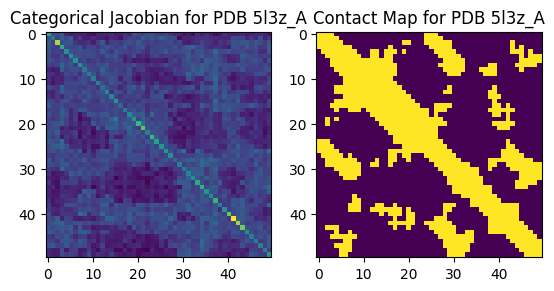

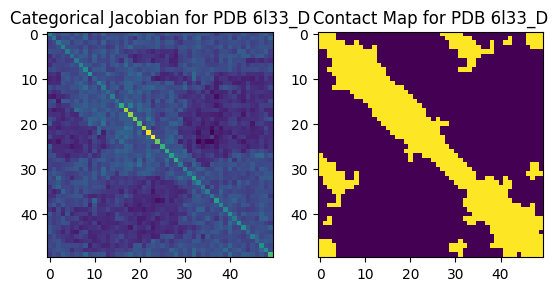

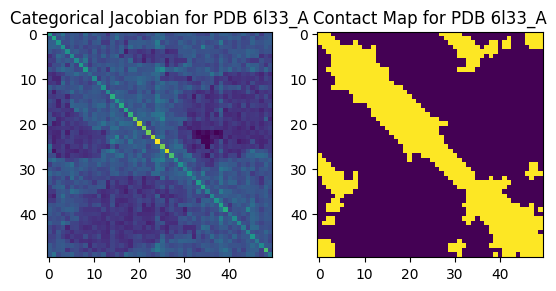

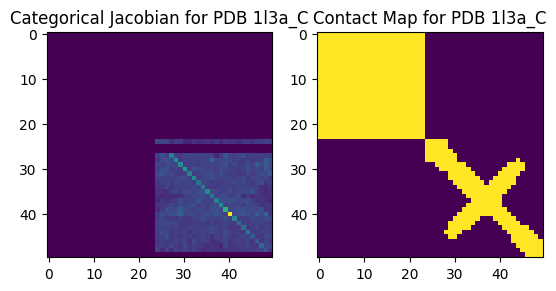

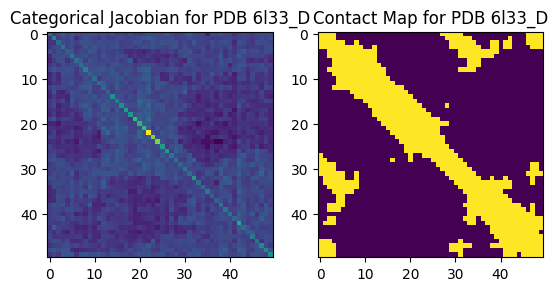

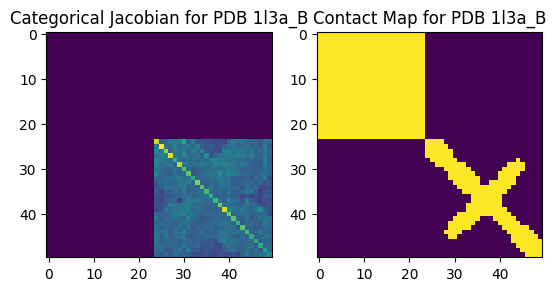

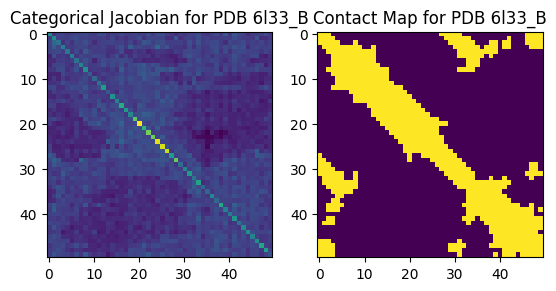

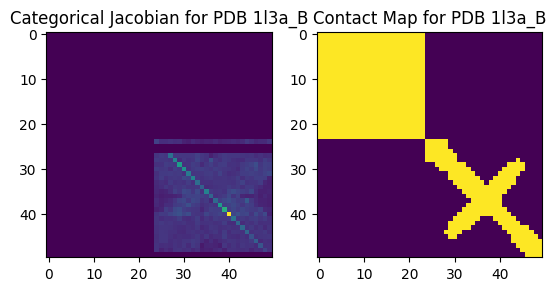

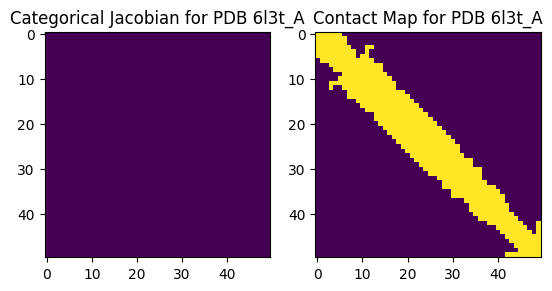

In [1]:
from training.training import main as run_training
import random
import numpy as np
import torch

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class MyArgs(object):
  def __init__(self):
    self.path_for_training_data = "./pdb_2021aug02_sample"
    self.path_for_outputs = "./content/test"
    self.previous_checkpoint = ""
    self.num_epochs = 50
    self.save_model_every_n_epochs = 5
    self.reload_data_every_n_epochs = 4
    self.num_examples_per_epoch = 200
    self.batch_size = 2000
    self.max_protein_length = 2000
    self.hidden_dim = 128
    self.num_encoder_layers = 3
    self.num_decoder_layers = 3
    self.num_neighbors = 32
    self.dropout = 0.1
    self.backbone_noise = 0.1
    self.rescut = 3.5
    self.debug = False
    self.gradient_norm = -1.0 #no norm
    self.decoder_use_full_cross_attention = False
    self.cross_attention_num_heads = 4
    self.mixed_precision = False
    self.compute_categorical_jacobian = True

args = MyArgs()
run_training(args)

## Categorical Jacobian of cross-attention model

/home/ubuntu/takehome-re-jacobastern/training/training.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/training/training.py:239: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/ubuntu/takehome-re-jacobastern/utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpi

Starting to compute Jacobian
Finished computing Jacobian
epoch: 1, step: 6, time: 1.6, train: 58.292, valid: 50.254, train_acc: 0.016, valid_acc: 0.014


100%|██████████| 6/6 [00:00<00:00, 21.89it/s]


epoch: 2, step: 12, time: 0.3, train: 48.484, valid: 37.555, train_acc: 0.020, valid_acc: 0.031


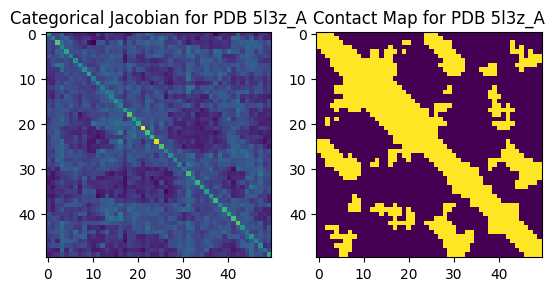

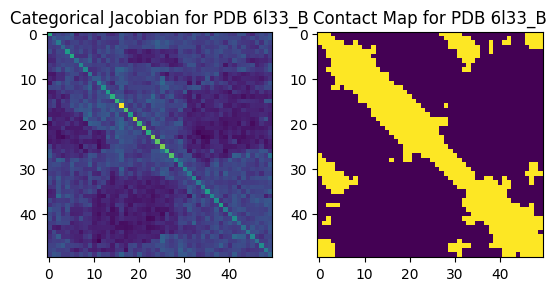

In [1]:
from training.training import main as run_training
import random
import numpy as np
import torch

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class MyArgs(object):
  def __init__(self):
    self.path_for_training_data = "./pdb_2021aug02_sample"
    self.path_for_outputs = "./content/test"
    self.previous_checkpoint = ""
    self.num_epochs = 2
    self.save_model_every_n_epochs = 5
    self.reload_data_every_n_epochs = 4
    self.num_examples_per_epoch = 200
    self.batch_size = 2000
    self.max_protein_length = 2000
    self.hidden_dim = 128
    self.num_encoder_layers = 3
    self.num_decoder_layers = 3
    self.num_neighbors = 32
    self.dropout = 0.1
    self.backbone_noise = 0.1
    self.rescut = 3.5
    self.debug = False
    self.gradient_norm = -1.0 #no norm
    self.decoder_use_full_cross_attention = True
    self.cross_attention_num_heads = 4
    self.mixed_precision = False
    self.compute_categorical_jacobian = True

args = MyArgs()
run_training(args)

## Observations
1. The categorical Jacobian looks a bit like a contact map. This is promising!
2. The categorical Jacobian is not sparse as I expected it to be. I'd have to do some more debugging here.
3. I would also like to quantitatively track the difference between the the categorical Jacobian and the contact map over training to see if the model improves at identifying these relationships.
4. I would also be interested in the residuals - the portion of the categorical Jacobian not explained by the contact map. That could possibly hint at functional relationships between residues beyond their structural proximity.

I ran out of time to log norms of model weights and activations.

# 5. Feedback

- This coding assessment is too big. 4 hours to read/understand the assessment, set up an environment, read over 1000 lines of code, come up with multiple model improvement proposals and multiple training loop improvement proposals, implement all of them, and answer the questions is a lot. I'd suggest asking the interviewee to answer each of these questions but only implement one model improvement.

- Also, this challenge seems pretty much impossible to do in time if you don't know ProteinMPNN - you would have to back out the model architecture from reading the code, which is possible but would take half of the allotted time. Providing a diagram of the architecture would set candidates on somewhat more equal footing.

- I might leave some low-hanging fruit for model improvements, rather than giving the user a model that is so good that it is still more-or-less SOTA 2 years after it was released. For example, remove the k_neighbors and allow the person doing the challenge to recognize that you could take some spatial shortcuts to avoid full self-attention.

- Provide a ready-built workspace for the user, ideally with conda/mamba installed and a conda environment that can run this code out-of-the-box.